# 3_modeling_evaluation_suto

In [2]:
import os

# Biblioteca built-in para obtenção de combinações
from itertools import combinations

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

# Bibliotecas de modelos
from pycaret.regression import * 
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge

from sklearn.utils.validation import check_is_fitted

from sklearn.model_selection import (cross_val_score, cross_validate, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

path_data = "../data/raw/"
path_interim_data = "../data/interim/"

# Parâmetros estéticos dos gráficos:
set_palette = "Paired"
axes_style = "ticks"

linha = 50*"-"

In [3]:
df_data = pd.read_parquet(path_interim_data+"df_data_step_1_output.pqt")

X_train_encoded = pd.read_parquet(path_interim_data+"X_train_encoded_step_2.pqt")
X_test_encoded = pd.read_parquet(path_interim_data+"X_test_encoded_2_output.pqt")

X_train_encoded = pd.concat([X_train_encoded.drop(['car name'], axis=1), df_data.loc[X_train_encoded.index, "mpg"]], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop(['car name'], axis=1), df_data.loc[X_test_encoded.index, "mpg"]], axis=1)

print(f"""Dimensões do dataset de treino: {X_train_encoded.shape}
Dimensões do dataset de validação: {X_test_encoded.shape}""")

Dimensões do dataset de treino: (357, 19)
Dimensões do dataset de validação: (40, 19)


## Testando um vários modelos de regressão usando o PyCaret

In [4]:
regression = setup(data=X_train_encoded, target='mpg')

best = compare_models(sort='MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.0689,8.0510,2.7886,0.8601,0.1148,0.0928,0.0090
ridge,Ridge Regression,2.0781,8.0646,2.7903,0.8597,0.1153,0.0934,0.0060
catboost,CatBoost Regressor,2.0738,8.5724,2.8894,0.8546,0.1111,0.0898,1.2770
et,Extra Trees Regressor,2.1290,9.3407,2.9791,0.8378,0.1125,0.0887,0.0580
gbr,Gradient Boosting Regressor,2.1145,9.6231,3.0283,0.8358,0.1164,0.0918,0.0250
xgboost,Extreme Gradient Boosting,2.2599,10.0753,3.0911,0.8279,0.1195,0.0973,0.2820
rf,Random Forest Regressor,2.4138,11.5989,3.3569,0.8016,0.1267,0.1031,0.0670
ada,AdaBoost Regressor,2.7879,14.1370,3.7165,0.7577,0.1452,0.1232,0.0240
omp,Orthogonal Matching Pursuit,3.0542,15.7758,3.9328,0.7254,0.1606,0.1366,0.0050
lasso,Lasso Regression,2.8977,16.0651,3.9669,0.7273,0.1534,0.1239,0.0050


## Testando regressão linear com regularização de rede elástica

### Rodando com valores padrões (*default*)

In [5]:
X = X_train_encoded.drop(['mpg'], axis=1)
y = X_train_encoded['mpg']
scoring='neg_mean_squared_error'
random_state=42

model = ElasticNet(random_state=random_state)
model.fit(X, y)

cross = cross_validate(model, X, y, cv=3, scoring=scoring,
                       return_train_score=True, return_estimator=True, n_jobs=-1)

for key in ['test_score', 'train_score']:
    print(f"""{key}: {round(-cross[key].mean(), 3)}""")

test_score: 8.666
train_score: 7.802


### Tunning do modelo

In [31]:
params = {"alpha":[0.001, 0.01, 0.05, 0.1],
          "l1_ratio":[0.75, 0.9, 0.98, 1],
          "selection":['cyclic', 'random']}

grid_search = GridSearchCV(estimator=model, param_grid=params,
                           scoring=scoring, cv=3, n_jobs=-1, return_train_score=True)

grid_search = grid_search.fit(X, y)

print(f"""Best hyperparameters: {grid_search.best_params_}""")
print(f"""{scoring}: {round(grid_search.score(X, y),3)}""")

for item in ["mean_test_score", "mean_train_score"]:
    print(f"""{item}: {round(np.mean(grid_search.cv_results_[item]), 3)}""")
    

Best hyperparameters: {'alpha': 0.01, 'l1_ratio': 1, 'selection': 'random'}
neg_mean_squared_error: -7.669
mean_test_score: -8.473
mean_train_score: -7.584


In [18]:
model = ElasticNet(**grid_search.best_params_, random_state=random_state)
model.fit(X, y)

cross = cross_validate(model, X, y, cv=3, scoring=scoring,
                       return_train_score=True, return_estimator=True, n_jobs=-1)

for key in ['test_score', 'train_score']:
    print(f"""{key}: {round(-cross[key].mean(), 3)}""")

test_score: 8.344
train_score: 7.513


In [14]:
try:
    check_is_fitted(model)
    print("Fittado.")
except:
    print("Não fittado.")


Fittado.


In [33]:
lst_columns = X_train_encoded.columns.tolist()[:-1]
coef_importance = pd.DataFrame(data=model.coef_.reshape(1,-1), columns=lst_columns)

## Plotando

In [87]:
def create_linspace_df(df, features_list=[None], elements_number=100):
    """
    O objetivo desta função é criar um dataframe com uma quantidade de registros igualmente espaçados,
    indicado para usar em regressão.
    
    Inputs:
        df: DataFrame do qual deseja-se criar o domínio igualmente espaçado.
        features_list: lista com as variáveis nu
        elements_number: 100
    
    Output:
        df_result: DataFrame
    """
    import pandas as pd
    
    if features_list[0]==None:
        features_list = df.select_dtypes(include=[float, "float32", "float64"]).columns
    else:
        pass
    
    df_result = pd.DataFrame()
    
    for feature in features_list:
        min_temp = int(df[feature].min()*.95)
        max_temp = int(df[feature].max()*1.05)
        df_result[feature] = np.linspace(min_temp, max_temp, num=elements_number, endpoint=True)
        
    return df_result

In [86]:
df_reg = create_linspace_df(X_train_encoded, features_list=lst_columns, elements_number=50)

# Obtendo as equações de reta para cada relação "fator vs 'mpg'".
dct_equations = {}

model = ElasticNet(**grid_search.best_params_, random_state=random_state)
model.fit(X, y)

str_equation = "y = "+str(round(model.intercept_, 2))

for coef, feature in zip(model.coef_, lst_columns):
    if -0.1 < coef < 0.1:
        pass
    else:
        str_equation += " + (" + str(round(coef, 2)) + "*"+feature+")"

df_reg["y_pred_mpg"] = model.predict(df_reg)
    
print(f"Dimensão da matriz: {df_reg.shape}")

str_equation

Dimensão da matriz: (50, 19)


'y = 11.91 + (0.79*model year) + (0.54*cylinders) + (0.31*origin) + (-1.62*acceleration)'

### Fatores mais importantes:

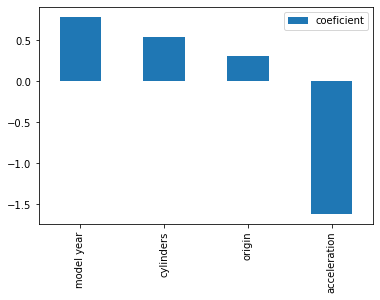

In [89]:
coef_importance = pd.DataFrame.from_dict(dict(zip(lst_columns, model.coef_)), orient='index', columns=['coeficient'])
coef_importance = coef_importance.loc[(coef_importance["coeficient"]>0.1) | (coef_importance["coeficient"]<-0.1),:]
# coef_importance
coef_importance.sort_values(by='coeficient', ascending=False).plot(kind='bar');
lst_columns = coef_importance.index

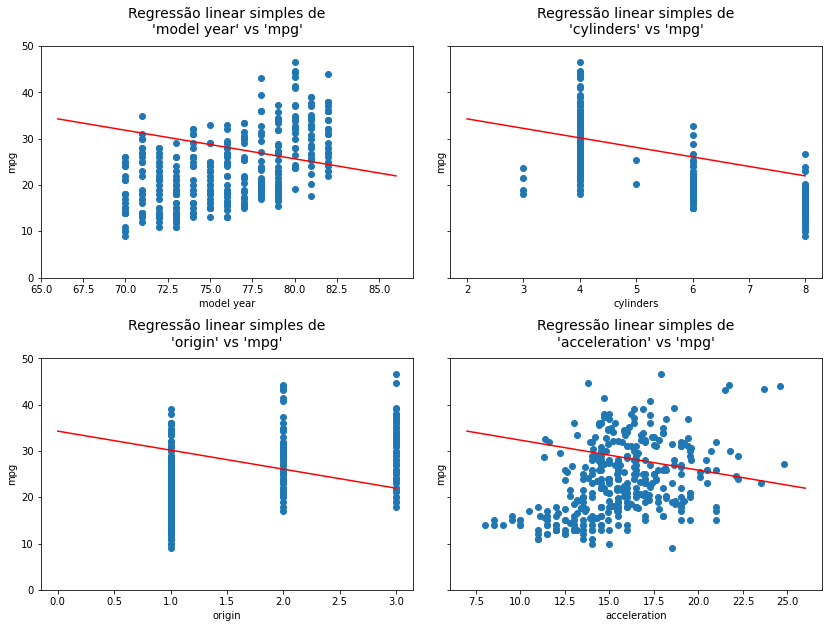

In [99]:
if len(lst_columns)%2==0:
    nrows = int(len(lst_columns)/2)
else:
    nrows = int(len(lst_columns)/2)+1

figsize_height = nrows*5

fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(14,figsize_height), sharey=True, gridspec_kw={'hspace': .35, 'wspace': .1})

row = col = 0

for i, feature in enumerate(lst_columns):
    axs[row, col].scatter(data=X_train_encoded, x=feature, y="mpg")
    # axs[row, col].scatter(data=df_reg, x=feature, y="y_pred_mpg", color='red', 'r-')
    axs[row, col].plot(df_reg[feature], df_reg["y_pred_mpg"], color='red')
    axs[row, col].set_title("Regressão linear simples de\n'"+feature+"' vs 'mpg'",
                            fontdict={'fontsize':14}, pad=12)
    axs[row, col].set(ylim=[0,50], xlabel=feature);
            
#     textstr = f""" Equação da reta: \n{str_equation}"""

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    
#     axs[row, col].text(.65, 0.96, textstr, transform=axs[row, col].transAxes, fontsize=12,
#         verticalalignment='top', bbox=props, color='red');

    if (i+1)%2!=0:
        col += 1
    else:
        col = 0
        row += 1
        
for ax in axs.flat:
    ax.set(ylabel='mpg')